In [1]:
import pandas as pd
import collections
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

np.set_printoptions(suppress=True)

%matplotlib inline

from sklearn.metrics import confusion_matrix

# Read and Clean Data

In [2]:
input_df = pd.read_csv('train.csv')
input_df.head()

,Tweet,following,followers,actions,is_retweet,location,Type
0,Good Morning Love @LeeBrown_V,0.0,0.0,0.0,0.0,"Pennsylvania, USA",Quality
1,'@realDonaldTrump @USNavy RIP TO HEROES',42096.0,61060.0,5001.0,0.0,"South Padre Island, Texas",Spam
2,Haven't been following the news but I understa...,0.0,0.0,NaN,0.0,Will never be broke ever again,Quality
3,pic.twitter.com/dy9q4ftLhZ What to do with pap...,0.0,0.0,0.0,0.0,Mundo,Quality
4,#DidYouKnow ► Mahatma Gandhi made a brief visi...,17800.0,35100.0,NaN,0.0,"Nottingham, England",Quality


In [3]:
# Check invalid values in the dataset
input_df.isnull().sum()

Tweet            0
following      158
followers       17
actions       3437
is_retweet       1
location      2011
Type             0
dtype: int64

In [4]:
# Drop columns with too many invalid values
input_df.drop(columns=['location', 'actions'], inplace=True)
input_df.dropna()

,Tweet,following,followers,is_retweet,Type
0,Good Morning Love @LeeBrown_V,0.0,0.0,0.0,Quality
1,'@realDonaldTrump @USNavy RIP TO HEROES',42096.0,61060.0,0.0,Spam
2,Haven't been following the news but I understa...,0.0,0.0,0.0,Quality
3,pic.twitter.com/dy9q4ftLhZ What to do with pap...,0.0,0.0,0.0,Quality
4,#DidYouKnow ► Mahatma Gandhi made a brief visi...,17800.0,35100.0,0.0,Quality
...,...,...,...,...,...
14894,"#AllWentWrongWhen I told my hair stylist to ""g...",695.0,533.0,1.0,Spam
14895,"They don't have to like you, and you don't hav...",0.0,0.0,0.0,Quality
14896,#Miami Graham Nash Live at Parker Playhouse #...,5647.0,15091.0,0.0,Spam
14897,@bethannhamilton is in the business of one-upp...,0.0,0.0,0.0,Quality


In [5]:
# Drop data points with invalid labels
input_df.drop(input_df[(input_df['Type'] != 'Quality') & (input_df['Type'] != 'Spam')].index, inplace=True)
input_df.Type.unique()

array(['Quality', 'Spam'], dtype=object)

In [6]:
from sklearn import preprocessing

# Encode labels in string format
le = preprocessing.LabelEncoder()
le.fit(input_df.Type.unique().tolist())
print(list(le.classes_))
input_df['Type'] = le.transform(input_df['Type'])

['Quality', 'Spam']


In [7]:
input_df.head()

,Tweet,following,followers,is_retweet,Type
0,Good Morning Love @LeeBrown_V,0.0,0.0,0.0,0
1,'@realDonaldTrump @USNavy RIP TO HEROES',42096.0,61060.0,0.0,1
2,Haven't been following the news but I understa...,0.0,0.0,0.0,0
3,pic.twitter.com/dy9q4ftLhZ What to do with pap...,0.0,0.0,0.0,0
4,#DidYouKnow ► Mahatma Gandhi made a brief visi...,17800.0,35100.0,0.0,0


In [8]:
from nltk.corpus import stopwords

# Drop stopwords in tweets and convert the text to lowercase
filtered_text = []
for i in range(0,len(input_df)):
    word_list = str(input_df.Tweet.iloc[i]).split()
    filtered_words = [word for word in word_list if word not in stopwords.words('english')]
    filtered_text.append(' '.join(filtered_words))
input_df['filtered_text'] = filtered_text
input_df['filtered_text_lower'] = input_df['filtered_text'].str.lower()

In [9]:
# Add a new feature of the count of numbers in each tweet
digits_list = []
for i in range(0,len(input_df)):
    if(sum(c.isdigit() for c in input_df.Tweet.iloc[i]) == 0):
        digits_list.append(0)
    else:
        digits_list.append(sum(c.isdigit() for c in input_df.Tweet.iloc[i]))

digits_col = pd.Series(digits_list)
input_df['digits'] = digits_col.values

In [10]:
# Add a new feature of the count of uppercase words in each tweet
cap_list = []
for i in range(0,len(input_df)):
    words = input_df.Tweet.iloc[i].split()
    count = 0
    for j in range(0,len(words)):
        if(words[j].isupper()):
            count = count + 1;
    cap_list.append(count)    
    #print(cap_list)
        
cap_col = pd.Series(cap_list)
input_df['cap'] = cap_col.values

In [11]:
input_df.head()

,Tweet,following,followers,is_retweet,Type,filtered_text,filtered_text_lower,digits,cap
0,Good Morning Love @LeeBrown_V,0.0,0.0,0.0,0,Good Morning Love @LeeBrown_V,good morning love @leebrown_v,0,0
1,'@realDonaldTrump @USNavy RIP TO HEROES',42096.0,61060.0,0.0,1,'@realDonaldTrump @USNavy RIP TO HEROES','@realdonaldtrump @usnavy rip to heroes',0,3
2,Haven't been following the news but I understa...,0.0,0.0,0.0,0,Haven't following news I understand #EFF dumbe...,haven't following news i understand #eff dumbe...,0,2
3,pic.twitter.com/dy9q4ftLhZ What to do with pap...,0.0,0.0,0.0,0,pic.twitter.com/dy9q4ftLhZ What paper scissors...,pic.twitter.com/dy9q4ftlhz what paper scissors...,2,0
4,#DidYouKnow ► Mahatma Gandhi made a brief visi...,17800.0,35100.0,0.0,0,#DidYouKnow ► Mahatma Gandhi made brief visit ...,#didyouknow ► mahatma gandhi made brief visit ...,6,0


In [12]:
# Separate ham and spam tweets
ham_df = input_df[input_df.Type == le.classes_.tolist().index('Quality')]
spam_df = input_df[input_df.Type == le.classes_.tolist().index('Spam')]

# Only use the same number of ham and spam tweets
ham_df = ham_df.sample(len(spam_df))
df = pd.concat([ham_df, spam_df])
df.head()

,Tweet,following,followers,is_retweet,Type,filtered_text,filtered_text_lower,digits,cap
5880,The title Queen of Puns means that you will be...,0.0,0.0,0.0,0,The title Queen Puns means showered them! @Gam...,the title queen puns means showered them! @gam...,0,0
554,The Face of PTSD http://fb.me/Awn90AGc,0.0,0.0,0.0,0,The Face PTSD http://fb.me/Awn90AGc,the face ptsd http://fb.me/awn90agc,2,1
14275,#Taurus thinks of money as an instrument for a...,NaN,51800.0,0.0,0,#Taurus thinks money instrument assuring good ...,#taurus thinks money instrument assuring good ...,0,0
12182,I just can't even today!,0.0,0.0,0.0,0,I can't even today!,i can't even today!,0,1
10337,Hate When I Accidentally Swipe Up My Music App,0.0,0.0,0.0,0,Hate When I Accidentally Swipe Up My Music App,hate when i accidentally swipe up my music app,0,1


In [13]:
print("Number of Spam tweets:",len(spam_df))
print("Number of Ham tweets:",len(ham_df))

Number of Spam tweets: 7443
Number of Ham tweets: 7443


# Exploratory Data Analysis

In [14]:
# Create lists of ham and spam tweets
spam_text = [spam_df.filtered_text.iloc[i] for i in range(0,len(spam_df))]
ham_text = [ham_df.filtered_text.iloc[i] for i in range(0,len(ham_df))]

### Common Words in Each Class of Tweets

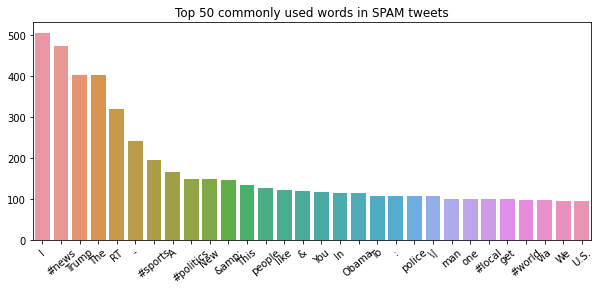

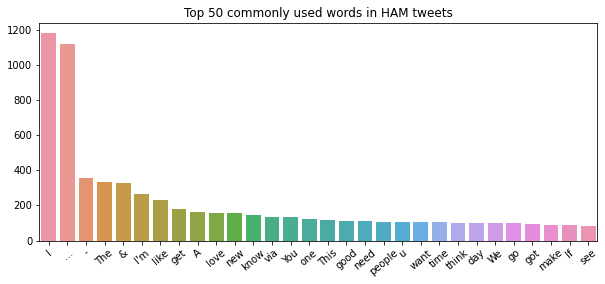

In [15]:
# Show top 50 commonly used words in SPAM tweets
spam_text = ' '.join(spam_text).split()
freq = nltk.FreqDist(spam_text).most_common(30)
freq = pd.Series(dict(freq))

# Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,4))

# Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
freq = sns.barplot(x=freq.index, y=freq.values, ax=ax)
plt.title("Top 50 commonly used words in SPAM tweets")
plt.xticks(rotation=40);

# Show top 50 commonly used words in HAM tweets
ham_text = ' '.join(ham_text).split()
freq = nltk.FreqDist(ham_text).most_common(30)
freq = pd.Series(dict(freq))

fig, ax = plt.subplots(figsize=(10,4))

freq = sns.barplot(x=freq.index, y=freq.values, ax=ax)
plt.title("Top 50 commonly used words in HAM tweets")
plt.xticks(rotation=40);

### Word Cloud for Spam Corpus

In [16]:
from wordcloud import (WordCloud, get_single_color_func)

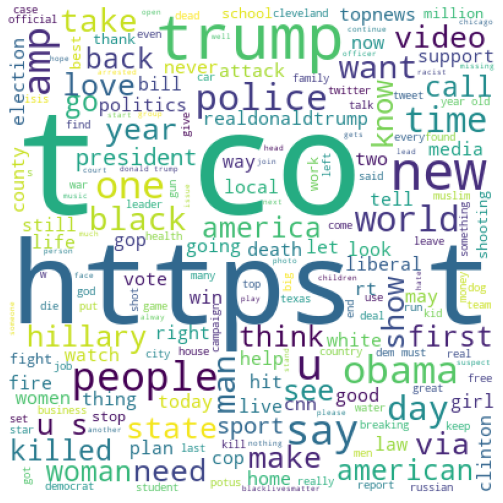

In [17]:
text = ''
for i in range(0,len(spam_df)):
    text = text + str(spam_df.filtered_text_lower.iloc[i])

plt.figure(figsize=(12,9))
wordcloud = WordCloud(background_color='white', width=400, height=400).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Word Cloud for Ham Corpus

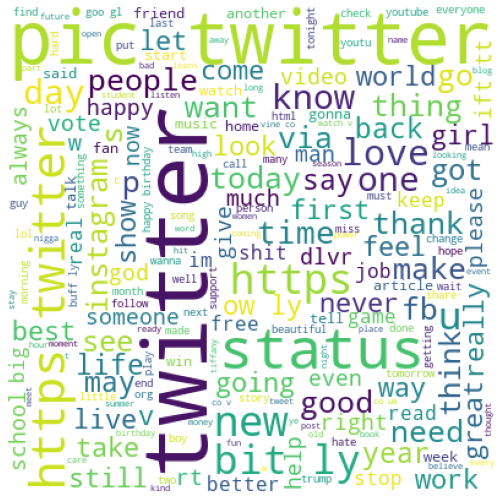

In [18]:
text = ''
for i in range(0,len(ham_df)):
    text = text + str(ham_df.filtered_text_lower.iloc[i])

plt.figure(figsize=(12,9))
wordcloud = WordCloud(background_color='white', width=400, height=400).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Other Features

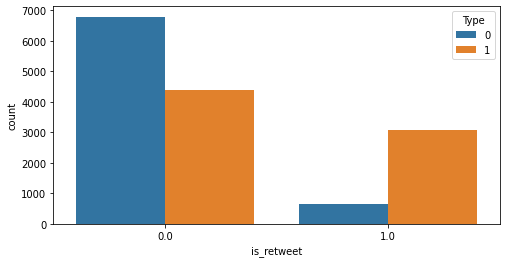

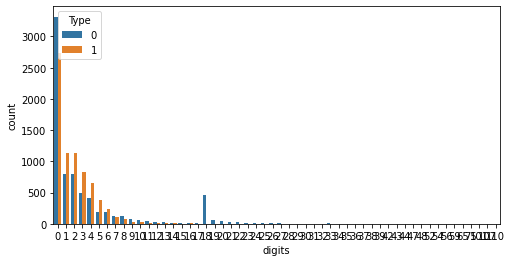

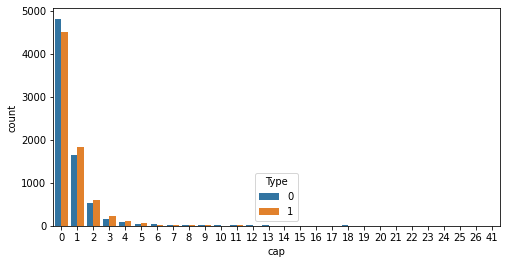

In [19]:
cols = ['is_retweet', 'digits', 'cap']
for i in range(len(cols)):
    plt.figure(figsize=(8,4))
    c = cols[i]
    sns.countplot(x=c, hue=df.Type, data=df)
    plt.show()

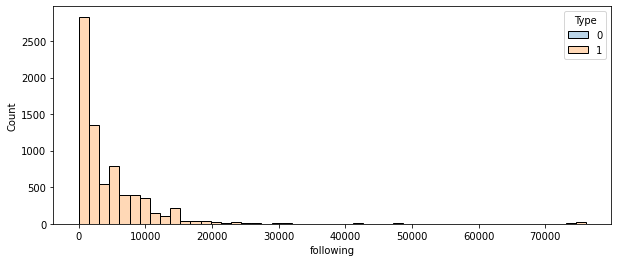

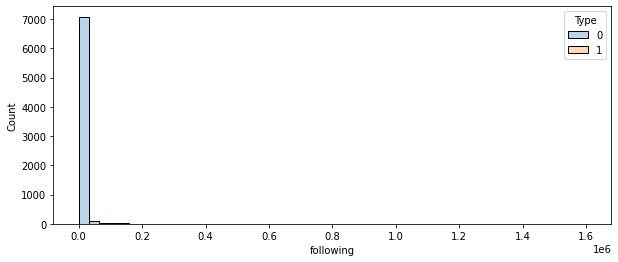

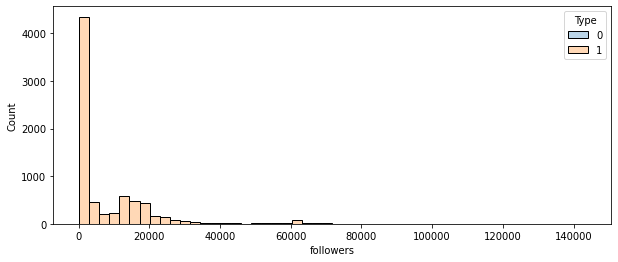

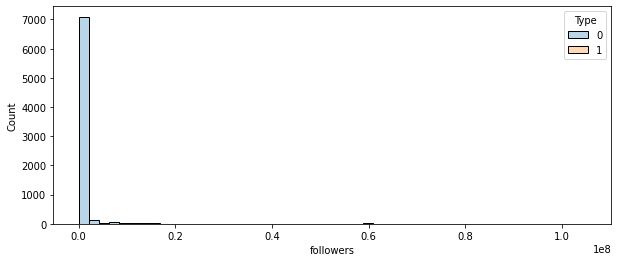

In [20]:
cols = ['following', 'followers']
for i in range(len(cols)):
    c = cols[i]
#     fig, ax = plt.subplots()
#     sns.histplot(df[c], ax=ax)
#     ax.set_xlim(1,100)
#     ax.set_xticks(range(1,100))
    plt.figure(figsize=(10,4))
    sns.histplot(x=c, alpha=0.3, hue=df.Type, data=spam_df, bins=50)
    plt.show()
    plt.figure(figsize=(10,4))
    sns.histplot(x=c, alpha=0.3, hue=df.Type, data=ham_df, bins=50)
    plt.show()

In [21]:
df.var(axis=0, numeric_only=True)

following     1.018180e+09
followers     1.514875e+13
is_retweet    1.875042e-01
Type          2.500168e-01
digits        2.548059e+01
cap           2.819932e+00
dtype: float64

All the non-textual features except for _is_retweet_ are largely overlapped between ham and spam tweets and do not seem very uesful to distinguish between the two classes.

Therefore, I will only use the textual feature. In textual data, it is clear that some words are more frequently used than the other words. TF-IDF Vectorizer will effectively extract meaningful word features.

# Naive Bayes Modeling

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_vector = tfidf_vectorizer.fit_transform(df['filtered_text_lower'])

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tfidf_vector.toarray(), df.Type, test_size=0.2, random_state=42)

In [24]:
from sklearn.naive_bayes import BernoulliNB

clf = BernoulliNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [25]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred, average='weighted')
print("F-measure for this model: ", f1*100, "%")

F-measure for this model:  90.78647477714979 %


In [26]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print("MAE for this model: ", mae)

MAE for this model:  0.09200805910006717


In [27]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test, y_pred)

TP = mat[0][0]
FP = mat[0][1]
FN = mat[1][0]
TN = mat[1][1]

# Sensitivity, hit rate, recall, or true positive rate
recall = TP/(TP+FN)
print("Recall: ",round(recall*100,2),"%")

# Precision or positive predictive value
precision = TP/(TP+FP)
print("Precision: ",round(precision*100,2),"%")

# Accuracy
accuracy = (TP+TN)/(TP+FP+FN+TN)
print("Accuracy: ",round(accuracy*100,2),"%")

Recall:  88.25 %
Precision:  94.26 %
Accuracy:  90.8 %
